## SMAVA

Test exercise - Question 1

In [1]:
## weaves
## smava

getwd()

## load in packages
library(Hmisc)

library(ranger)
library(MASS)
library(tidyverse)
library(e1071)

library(rpart)
library(rpart.plot)
library(ipred)
library(mlbench)
library(pROC)
library(gbm)
library(dplyr)
library(caret)

library(doMC)

registerDoMC(cores = detectCores(all.tests = FALSE, logical = TRUE))

options(useFancyQuotes = TRUE)

[1] "/misc/build/0/pyeg0/caret/classr1"

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.3     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()    masks stats::filter()
x dplyr::lag()       masks stats::lag()
x dplyr::select()    masks MASS::select()
x dplyr::src()       masks Hmisc::src()
x dplyr::summarize() masks Hmisc::summarize()


Attaching package: 'e1071'


The following object is masked from 'package:Hmisc':

    impute



Attaching package: 'rpart'


The following object is masked from 'package:survival':

    solder


Type 'citation("pROC")' for a citation.


Attac

In [2]:
## Data sets

load("bak/in/train.rdata")
load("bak/in/test.rdata")

train0 <- data.frame(train) # a local copy.

# Carry some configuration data
smava0 <- list()

# See some summaries.
sapply(train, class)
sapply(train, summary)

## Order to highlight NA pattern.

## The outcome variable accepted is balanced. So need to upsample.

## customerNumber has 15000 unique.

## NA's on interestRate, and x2. x2 is specific to customer.

## interestRate is for regression analysis later

fnas <- function(x) sum(as.integer(is.na(train[[x]])))
fnas("x2")
fnas("interestRate")

## interestRate is only given for accepted
train[(train$accepted == "NO") & !is.na(train$interestRate), c("accepted", "interestRate")]

customerNumber           bank             x1             x2             x3 
     "integer"       "factor"      "numeric"      "numeric"      "numeric" 
            x4             x5             x6             x7             x8 
     "numeric"      "numeric"       "factor"       "factor"      "numeric" 
            x9            x10       accepted   interestRate 
     "numeric"      "numeric"       "factor"      "numeric"

$customerNumber
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2    7551   15105   15054   22518   29997 

$bank
  B1  B10  B11  B12  B13  B14  B15  B16  B17  B18  B19   B2  B20  B21  B22  B23 
4603 4495 4424 4509 4479 4492 4418 4547 4565 4402 4410 4541 4444 4496 4504 4522 
 B24  B25  B26  B27  B28  B29   B3  B30   B4   B5   B6   B7   B8   B9 
4518 4513 4569 4473 4565 4444 4480 4463 4424 4508 4479 4542 4588 4552 

$x1
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.02433  0.49992  1.00460  1.65895  1.95799 75.79947 

$x2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.01    0.97    2.71    8.17    7.36  910.95   40520 

$x3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.35  166.00  199.11  199.34  232.74  382.41 

$x4
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.5489  -0.7509   1.9963   1.9581   4.6776  18.8855 

$x5
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.6414  -0.7914   1.9706   1.9340   4.6317  18.2838 

$x6
  A

[1] 40520

[1] 68364

accepted,interestRate
<fct>,<dbl>


In [3]:
## No obvious rule
## sapply(train[is.na(train$x2),], summary)
## sapply(train[!is.na(train$x2),], summary)

## x2 is blank for a type of customer.

train1 <- train[order(train$customerNumber, train$bank),]
outcomes <- (train1$accepted == "YES") * 1
## store the outcomes as numerics.
train1$outcomes <- outcomes

smava0$outcomes <- outcomes

idx <- as.vector(sapply(train1, class, USE.NAMES=FALSE) == "factor")
smava0$cs <- colnames(train1)[idx]

for(c in smava0$cs) {
  train1[[c]] <- as.numeric(train1[[c]])
}

train2 <- train1 %>% dplyr::select(customerNumber, x2) %>% 
group_by(customerNumber) %>% summarise(n = n(), na0 = sum(is.na(x2))) 

In [4]:
## And is all NA at all banks for a set of customers.

### Sanity check

## This is an empty set. For all those records where n is not equal to the number of nas in x2 for
## that customer.
train2[ (train2$n != train2$na0) && (train2$na0 > 0),]
## TODO
## I should check the bank hits too.
## NOTE
## It isn't easy to impute with this.

## capture those customers who have x2 at NA.

smava0$"null-customer" <- train2[train2$na0 > 0, "customerNumber"][["customerNumber"]]
length(smava0$"null-customer")

customerNumber,n,na0
<int>,<int>,<int>


[1] 4488

In [5]:
## store some colnames sets.

col0 <- colnames(train1)
smava0$results <- train1[c("accepted", "interestRate")]
smava0$ctl <- train1[c("customerNumber", "bank")]
smava0$nullcols <- c("x2")
## outcomes comes in as a feature.
smava0$ft0 <- setdiff(col0, union(colnames(smava0$results), colnames(smava0$ctl)))
smava0$ft0 <- c(smava0$ft0, "bank")
##

save(train1, smava0, file="smava0.dat")

In [6]:
## Correlations dataset.
## The same record may fail or succeed depending on the bank.
## I haven't encoded the bank, because you would hope banks follow similar policies.
## So we may have records that are identical but fall once and succeed at another bank.
## This just for correlations.

## Let's add a boolean for when x2 is null and assign the mean of x2 as the value.

load("smava0.dat", envir=.GlobalEnv)

train1$x2na <- 0
train1[ is.na(train1$x2), "x2na" ] <- 1
smava0$x2impute <- as.vector(summary(train1$x2)['Mean'])
train1[ is.na(train1$x2), "x2" ] <- smava0$x2impute

In [7]:
## Pair-plot
train1p <- train1[, c(smava0$ft0, "x2na") ]

In [8]:
nm0.fspec <- paste("smava0", "pp", "-%03d.jpeg", sep ="")

jpeg(width=1024, height=768, filename= nm0.fspec)
plot(train1p)
dev.off()

In [ ]:
## correlations

smava0$cor <- cor(train1p)

jpeg(filename=paste("smava0", "cc", "-%03d.jpeg", sep=""),
     width=1024, height=768)

corrplot::corrplot(smava0$cor, method="number", order="hclust")

dev.off()

ihcor <- findCorrelation(smava0$cor, cutoff = .75, verbose = FALSE)
smava0$hcor <- colnames(train1p)[ihcor]

## This is encouraging. x3 is -0.98 with x10 and x10 is -0.21 with outcomes.
## Let's discard x3 because it duplicates x10

## Near Zero Variables

nzv0 <- nearZeroVar(train1p, saveMetrics = TRUE, allowParallel=TRUE, freqCut =95/5, uniqueCut=10)
all(!nzv0$nzv)
all(!nzv0$zeroVar)

## So good distributions.

In [15]:
## Dataset 1

## Remove x3, remove all blank x2, leave bank in.
## Try a fast GBM using all cores.

train1n <- data.frame(train1p)

## because I've used outcomes as a numerical column. I now convert it back to labels.
## It must be a valid R variable name, so convert the numbers to a factor, and relabel the
## the levels.
outcomes <- as.factor(train1n$outcomes)
outcomes <- factor(outcomes, levels = c("0", "1"), labels = c("No", "Yes"))

## Center and scale

xcols <- union(smava0$hcor, "outcomes")
cols <- setdiff(colnames(train1n), xcols)
smava0$ft1 <- cols
train1n <- train1n[,smava0$ft1]

## Store this prepro
smava0$pp <- preProcess(train1n, method = c("center", "scale"))

df0 <- predict(smava0$pp, train1n)

## simple controls

fitControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    ## repeated a few times
    repeats = 3,
    summaryFunction = twoClassSummary,
  classProbs = TRUE)

gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3),
                       n.trees = (1:20)*10,
                       shrinkage = 0.1,
                       n.minobsinnode = 20)

In [16]:
fit0 <- train(df0, outcomes, method = "gbm", 
              trControl = fitControl,
              tuneGrid = gbmGrid,
              metric = "ROC",
              verbose = FALSE)

smava0$gbm <- fit0

trainPred <- predict(fit0, df0)
# postResample(testPred, testClass)

conf0 <- confusionMatrix(trainPred, outcomes, positive = "Yes")
conf0

## Only 65% accurate on the whole set!

nvars <- floor(length(colnames(df0)) * 2/3)

jpeg(filename=paste("smava0", "mf", "-%03d.jpeg", sep=""), 
     width=1024, height=768)

modelImp <- varImp(fit0, scale = FALSE)
plot(modelImp, top = min(dim(modelImp$importance)[1], nvars) )

## Get a density and a ROC
## You need twoClassSummary for this

x.p <- predict(fit0, df0, type = "prob")[2]

test.df <- data.frame(true0=x.p[[ "Yes" ]], Obs=outcomes)
test.roc <- roc(Obs ~ true0, test.df)

densityplot(~test.df$true0, groups = test.df$Obs, auto.key = TRUE)

plot.roc(test.roc)

dev.off()

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  48485 26267
       Yes 19879 40338
                                          
               Accuracy : 0.6581          
                 95% CI : (0.6556, 0.6606)
    No Information Rate : 0.5065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3152          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6056          
            Specificity : 0.7092          
         Pos Pred Value : 0.6699          
         Neg Pred Value : 0.6486          
             Prevalence : 0.4935          
         Detection Rate : 0.2989          
   Detection Prevalence : 0.4462          
      Balanced Accuracy : 0.6574          
                                          
       'Positive' Class : Yes             
                  

Setting levels: control = No, case = Yes

Setting direction: controls < cases



png 
  2

In [32]:
## Write out our training data.

save(df0, outcomes, smava0, file = "smava00-fit.dat")

In [29]:
## Make a prediction using test.

## Apply the same data pre-processing and predict.

## Don't do the order.

test0 <- data.frame(test) # just an backup to use in the interpreter.
test1 <- data.frame(test)

for(c in intersect(smava0$cs, colnames(test))) {
  test1[[c]] <- as.numeric(test1[[c]])
}

In [ ]:
## Impute with Hmisc

#load data
data("iris")

#seed missing values ( 10% )
iris.mis <- prodNA(iris, noNA = 0.1)
summary(iris.mis)

# impute with mean value
iris.mis$imputed_age <- with(iris.mis, impute(Sepal.Length, mean))

# impute with random value
iris.mis$imputed_age2 <- with(iris.mis, impute(Sepal.Length, 'random'))

#similarly you can use min, max, median to impute missing value

#using argImpute
impute_arg <- aregImpute(~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width +Species, data = iris.mis, n.impute = 5) 

In [30]:
test1$x2na <- 0
test1[ is.na(test1$x2), "x2na" ] <- 1
test1[ is.na(test1$x2), "x2" ] <- smava0$x2impute

test1n <- test1[, smava0$ft1]

## pre-process
df0 <- predict(smava0$pp, test1n)

testPred <- predict(smava0$gbm, df0)

predictions <- data.frame(test)
predictions$predictionAccepted <- testPred

save(predictions, file="predictions.rdata")

In [31]:
head(predictions)

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,predictionAccepted
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,17652,B4,2.6999043,NA,289.8060,3.5062855,3.019291,ACS,P0DI0,6.132490,0.2024692,0.2340533,No
2,5083,B2,1.7768174,NA,149.4808,8.6785405,1.561671,ACS,WXATN,9.602027,0.6035512,0.4728191,No
3,14485,B27,9.2014608,15.2018994,168.5305,0.6861547,-2.659850,FBW,YVNYM,-1.843895,0.3604684,0.4297722,No
4,24278,B12,0.2425088,0.8906478,144.3519,8.9942867,3.757424,ACS,WXATN,13.329596,0.2102926,0.4851283,Yes
5,18816,B29,1.8619350,0.9441711,330.2783,11.1829245,1.795021,FBW,KT4RM,12.944497,0.1193745,0.1910898,No
6,25518,B25,8.9591239,9.3258122,138.9361,9.5992959,4.778473,ACS,LURGJ,14.795508,0.9447004,0.4984742,Yes


## More transformations

spatialSign

[1]  0.1780146 -0.3204162  0.7294097  0.4736167 -0.3305951

-0.05490429,0.96472851,0.2574576
0.77509563,-0.28829786,-0.5622376
-0.59129730,0.77374567,0.2273437
-0.04072324,0.02943995,0.9987367


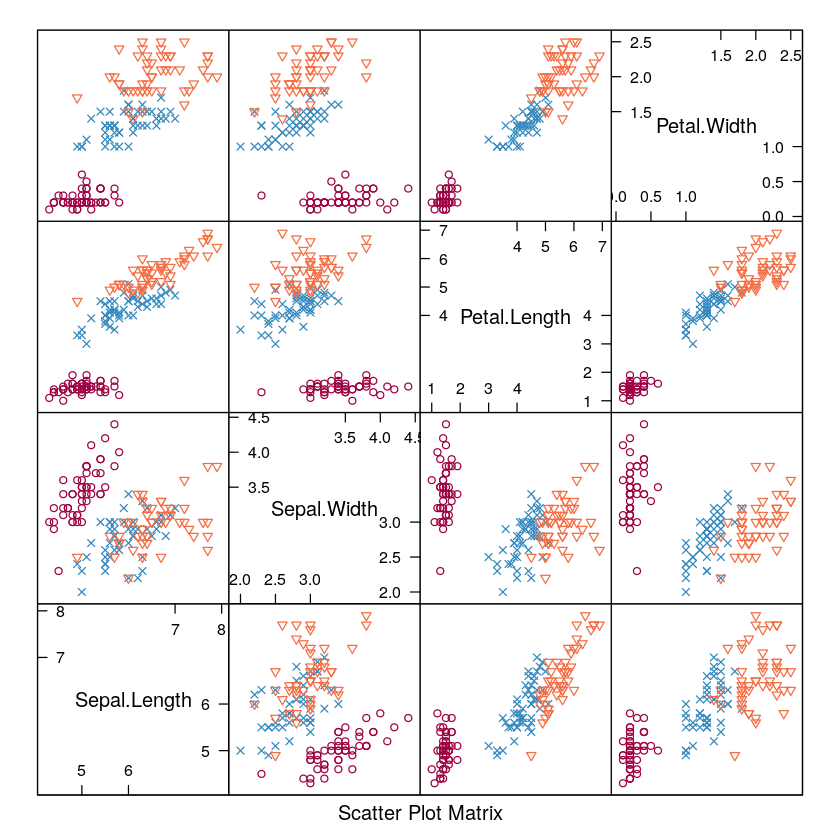

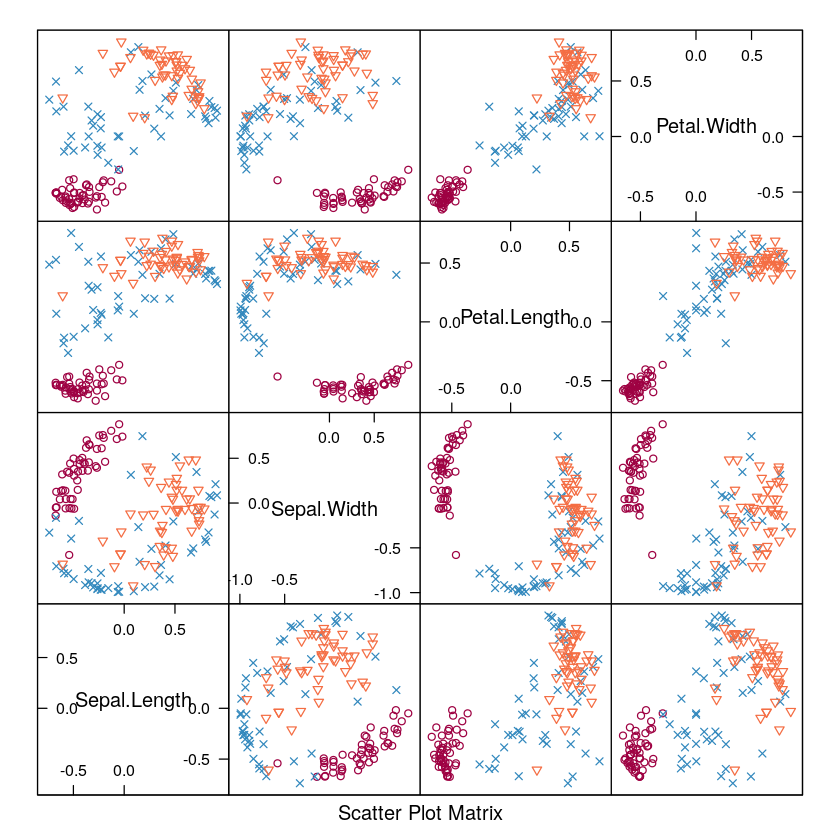

In [7]:
spatialSign(rnorm(5))

spatialSign(matrix(rnorm(12), ncol = 3))

# should fail since the fifth column is a factor
try(spatialSign(iris), silent = TRUE)

trellis.par.set(caretTheme())

featurePlot(iris[,-5], iris[,5], "pairs")
featurePlot(spatialSign(scale(iris[,-5])), iris[,5], "pairs")